<a href="https://colab.research.google.com/github/kskim-phd/AI_vs_FS/blob/main/4_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" kde.py """
import matplotlib.pyplot as plt

def kde(data, n=2**14, MIN=None, MAX=None, plot=False, label = []):
#==============================================================================
# Reliable and extremely fast kernel density estimator for one-dimensional data;
#        Gaussian kernel is assumed and the bandwidth is chosen automatically;
#        Unlike many other implementations, this one is immune to problems
#        caused by multimodal densities with widely separated modes (see example). The
#        estimation does not deteriorate for multimodal densities, because we never assume
#        a parametric model for the data.
# INPUTS:
#     data    - a vector of data from which the density estimate is constructed;
#          n  - the number of mesh points used in the uniform discretization of the
#               interval [MIN, MAX]; n has to be a power of two; if n is not a power of two, then
#               n is rounded up to the next power of two, i.e., n is set to n=2^ceil(log2(n));
#               the default value of n is n=2^12;
#   MIN, MAX  - defines the interval [MIN,MAX] on which the density estimate is constructed;
#               the default values of MIN and MAX are:
#               MIN=min(data)-Range/10 and MAX=max(data)+Range/10, where Range=max(data)-min(data);
#    plot     -  (True/False) whether or not to produce a plot
#    label    -  (string) label to apply to kde plot

# OUTPUTS:
#   bandwidth - the optimal bandwidth (Gaussian kernel assumed);
#     density - column vector of length 'n' with the values of the density
#               estimate at the grid points;
#     xmesh   - the grid over which the density estimate is computed;
#             - If no output is requested, then the code automatically plots a graph of
#               the density estimate.
#        cdf  - column vector of length 'n' with the values of the cdf
#  Reference:
# Kernel density estimation via diffusion
# Z. I. Botev, J. F. Grotowski, and D. P. Kroese (2010)
# Annals of Statistics, Volume 38, Number 5, pages 2916-2957.

#
#  Example:
#              kde(data,2**14,min(data)-5,max(data)+5);
#
#  Notes:   If you have a more reliable and accurate one-dimensional kernel density
#           estimation software, please email me at botev@maths.uq.edu.au

#==============================================================================
    import numpy as np
    from scipy import optimize

	# Auxiliary Functions
    #==========================================================================
    def fixed_point(t,N,I,a2):
        # This implements the function t-zeta*gamma^[l](t)
        l=7
        f=2*np.pi**(2*l) * sum(I**l*a2*np.exp(-I*np.pi**2*t))

        for s in range(l-1,1,-1):
            K0    = np.prod(range(1,2*s,2))/np.sqrt(2*np.pi)
            const = (1+(1/2)**(s+1/2))/3
            time  = (2*const*K0/N/f)**(2/(3+2*s))
            f     = 2*np.pi**(2*s)*sum(I**s*a2*np.exp(-I*np.pi**2*time))

        return t-(2*N*np.sqrt(np.pi)*f)**(-2/5)
    #==========================================================================
    def dct1d(data):
        # computes the discrete cosine transform of the column vector data
        nrows = len(data)
        # Compute weights to multiply DFT coefficients
        weight = 2*(np.exp(-1j*np.array(range(1,nrows))*np.pi/(2*nrows)))
        weight = np.append(1,weight)
        # Re-order the elements of the columns of x
        data = np.append(data[::2],data[:0:-2])
        # Multiply FFT by weights:
        data = (weight*np.fft.fft(data)).real

        return data
    #==========================================================================
    def idct1d(data):
		# computes the discrete cosine transform of the column vector data
        nrows = len(data)
		# Compute weights to multiply DFT coefficients
        weights = nrows*np.exp(1j*(np.arange(nrows))*np.pi/(2*nrows))
		# Multiply FFT by weights:
        data = np.real(np.fft.ifft(weights * data))
        # Re-order the elements of the columns of x
        output = np.arange(nrows, dtype = 'd')
        output[::2] = data[0:int(nrows/2)]
        output[1::2] = data[:int(nrows/2)-1:-1]

		#   Reference:
		#     A. K. Jain, "Fundamentals of Digital Image
		#     Processing", pp. 150-153.

        return output

   # Main Function
   #===========================================================================
    data = np.array(data)   #Make data a numpy array

    n=int(2**np.ceil(np.log2(n))) #round up n to the next power of 2;

	#define the default  interval [MIN,MAX]

    if MAX == None or MIN == None:
        minimum = min(data)
        maximum = max(data)
        Range   = maximum - minimum

        if MAX == None:
            MAX=maximum+Range/10

        if MIN == None:
            MIN=minimum-Range/10


	# set up the grid over which the density estimate is computed;
    R=MAX-MIN; dx=R/(n-1)
    xmesh=np.arange(MIN,MAX+dx,dx, dtype = 'd')
    bins = np.append(xmesh, xmesh[-1])
    N=len(np.unique(data))
	# bin the data uniformly using the grid defined above;
    initial_data= np.histogram(data, bins = bins)[0]/N
    initial_data=initial_data/sum(initial_data)

	# discrete cosine transform of initial data
    a=dct1d(initial_data)

	# now compute the optimal bandwidth^2 using the referenced method
    I=np.arange(1,n,dtype = "d")**2; a2=(a[1:]/2)**2

	# solve the equation t=zeta*gamma^[5](t)
    t_star = optimize.root(lambda t: fixed_point(t,N,I,a2), 0.05)
    if t_star.success == False:
        t_star = 0.28*N**(-2/5)
    else:
        t_star = t_star.x
	# smooth the discrete cosine transform of initial data using t_star
    a_t=a*np.exp(-np.arange(0,n, dtype = "d")**2*np.pi**2*t_star/2)

	# now apply the inverse discrete cosine transform
    density=idct1d(a_t)/R
	# take the rescaling of the data into account
    bandwidth=np.sqrt(t_star)*R

    # for cdf estimation
    f=2*np.pi**2*sum(I*a2*np.exp(-I*np.pi**2*t_star))
    t_cdf=(np.sqrt(np.pi)*f*N)**(-2/3)
	# now get values of cdf on grid points using IDCT and cumsum function
    a_cdf=a*np.exp(-np.arange(0,n,dtype="d")**2*np.pi**2*t_cdf/2)
    cdf=np.cumsum(idct1d(a_cdf))*(dx/R)
	#take the rescaling into account if the bandwidth value is required
    bandwidth_cdf=np.sqrt(t_cdf)*R

    if plot==True:
        if label:
            plt.plot(xmesh, density, label = label)
            plt.legend()
        else:
             plt.plot(xmesh, density)
        plt.ylim(bottom=0)


    return [bandwidth,density,xmesh,cdf]
	#==========================================================================

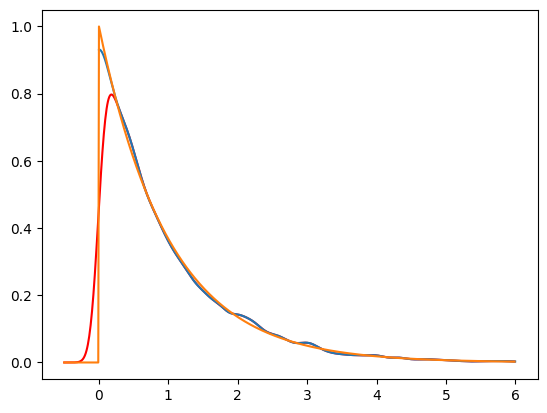

In [ ]:
# gausthetakde.py

import matplotlib.pyplot as plt
import numpy as np

sig = 0.1; sig2 = sig**2; c = 1/np.sqrt(2*np.pi)/sig #Constants
phi = lambda x,x0: np.exp(-(x-x0)**2/(2*sig2)) #Unscaled Kernel
f = lambda x: np.exp(-x)*(x >= 0) # True PDF
n = 10**4 # Sample Size
x =-np.log(np.random.uniform(size=n))# Generate Data via IT method
xx = np.arange(-0.5,6,0.01, dtype = "d")# Plot Range
phis = np.zeros(len(xx))
for i in range(0,n):
    phis = phis + phi(xx,x[i])
phis = c*phis/n
plt.plot(xx,phis,'r')# Plot Gaussian KDE
[bandwidth,density,xmesh,cdf] = kde(x,2**12,0,max(x))
idx = (xmesh <= 6)
plt.plot(xmesh[idx],density[idx])# Plot Theta KDE
plt.plot(xx,f(xx))# Plot True PDF

# 4.5 Clustering via Mixture Models

In [ ]:
"""  EMclust.py """
import numpy as np
from scipy.stats import multivariate_normal

Xmat = np.genfromtxt('https://raw.githubusercontent.com/DSML-book/Programs/refs/heads/master/Chapter4/clusterdata.csv', delimiter=',')
K = 3
n, D = Xmat.shape

W = np.array([[1/3,1/3,1/3]])
M  = np.array([[-2.0,-4,0],[-3,1,-1]])  #stores the mu's as columns
C = np.zeros((3,2,2))

C[:,0,0] = 1
C[:,1,1] = 1

p = np.zeros((3,300))

for i in range(0,100):

    for k in range(0,K):    #E-step
        mvn = multivariate_normal( M[:,k].T, C[k,:,:] )
        p[k,:] = W[0,k]*mvn.pdf(Xmat)

    p = p/sum(p,0)   #normalize

    W = np.mean(p,1).reshape(1,3)
    for k in range(0,K):
        M[:,k] = (Xmat.T @ p[k,:].T)/sum(p[k,:])
        xm = Xmat.T - M[:,k].reshape(2,1)
        C[k,:,:] = xm @ (xm*p[k,:]).T/sum(p[k,:])

print(W)

[[0.3303 0.3206 0.349 ]]


# 4.6 Clustering via Vector Quantization

In [ ]:
""" Kmeans.py """
import numpy as np
Xmat = np.genfromtxt('clusterdata.csv', delimiter=',')
K = 3
n, D = Xmat.shape
c  = np.array([[-2.0,-4,0],[-3,1,-1]])  #initialize centers
cold = np.zeros(c.shape)
dist2 = np.zeros((K,n))
#for h in range(0,100):
while np.abs(c - cold).sum() > 0.001:
   cold = c.copy()
   for i in range(0,K): #compute the squared distances
        dist2[i,:] = np.sum((Xmat - c[:,i].T)**2, 1)

   label = np.argmin(dist2,0) #assign the points to nearest centroid
   minvals = np.amin(dist2,0)
   for i in range(0,K): # recompute the centroids
       c[:,i] = np.mean(Xmat[np.where(label == i),:], 1).reshape(1,2)

print('Loss = {:3.3f}'.format(minvals.mean()))

Loss = 2.288


In [ ]:
""" clustCE.py """
import numpy as np
np.set_printoptions(precision=4)

Xmat = np.genfromtxt('clusterdata.csv', delimiter=',')
K = 3
n, D = Xmat.shape

def Scluster(c):
    n, D = Xmat.shape
    dist2 = np.zeros((K,n))
    cc = c.reshape(D,K)
    for i in range(0,K):
        dist2[i,:] = np.sum((Xmat - cc[:,i].T)**2, 1)
    minvals = np.amin(dist2,0)
    return minvals.mean()

numvar = K*D
mu = np.zeros(numvar)  #initialize centers
sigma = np.ones(numvar)*2
rho = 0.1
N = 500; Nel = int(N*rho); eps = 0.001

func = Scluster
best_trj = np.array(numvar)
best_perf = np.inf
trj = np.zeros(shape=(N,numvar))

while(np.max(sigma)>eps):
        for i in range(0,numvar):
            trj[:,i] = (np.random.randn(N,1)*sigma[i]+ mu[i]).reshape(N,)
        S = np.zeros(N)
        for i in range(0,N):
            S[i] = func(trj[i])

        sortedids = np.argsort(S) # from smallest to largest
        S_sorted = S[sortedids]
        best_trj = np.array(n)
        best_perf = np.inf
        eliteids = sortedids[range(0,Nel)]
        eliteTrj = trj[eliteids,:]
        mu = np.mean(eliteTrj,axis=0)
        sigma = np.std(eliteTrj,axis=0)

        if(best_perf>S_sorted[0]):
            best_perf = S_sorted[0]
            best_trj = trj[sortedids[0]]

print(best_perf)
print(best_trj.reshape(2,3))

2.287130758970881
[[ 0.5879 -1.9282 -3.868 ]
 [-1.3523 -3.0415  0.0459]]


# 4.7 Hierarchical Clustering

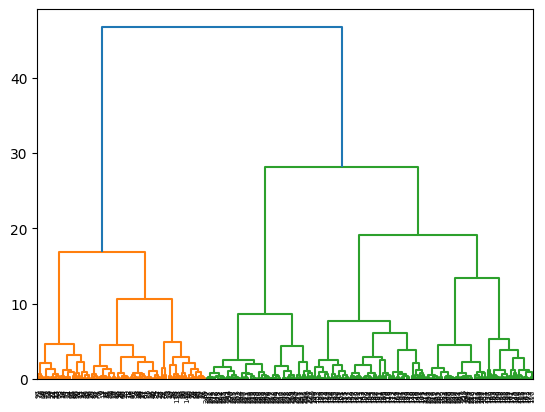

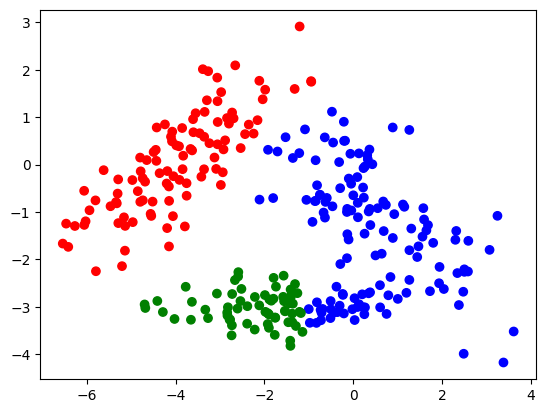

In [ ]:
""" AggCluster.py """
import numpy as np
from scipy.spatial.distance import cdist

def update_distances(D,i,j, sizes): # calculate distances for merged cluster
    n = D.shape[0]
    d = np.inf * np.ones(n+1)
    for k in range(n): # Update distances
       d[k] = ((sizes[i]+sizes[k])*D[i,k] +
       (sizes[j]+sizes[k])*D[j,k] -
       sizes[k]*D[i,j])/(sizes[i] + sizes[j] + sizes[k])

    infs =  np.inf * np.ones(n) # array of infinity
    D[i,:],D[:,i],D[j,:],D[:,j] =  infs,infs,infs,infs # deactivate
    new_D = np.inf * np.ones((n+1,n+1))
    new_D[0:n,0:n] = D # copy old matrix into new_D
    new_D[-1,:], new_D[:,-1] = d,d # add new row and column
    return new_D

def agg_cluster(X):
    n = X.shape[0]
    sizes = np.ones(n)
    D = cdist(X, X,metric = 'sqeuclidean')   # initialize distance matr.
    np.fill_diagonal(D, np.inf * np.ones(D.shape[0]))
    Z = np.zeros((n-1,4))  #linkage matrix encodes hierachy tree
    for t in range(n-1):
        i,j = np.unravel_index(D.argmin(), D.shape) # minimizer pair
        sizes = np.append(sizes, sizes[i] + sizes[j])
        Z[t,:]=np.array([i, j, np.sqrt(D[i,j]), sizes[-1]])
        D = update_distances(D, i,j, sizes)  # update distance matr.
    return Z

# MAIN ROUTINE
import scipy.cluster.hierarchy as h

X = np.genfromtxt('clusterdata.csv',delimiter=',') # read the data
Z = agg_cluster(X)  # form the linkage matrix

h.dendrogram(Z) # SciPy can produce a dendogram from Z
# fcluster function assigns cluster ids to all points based on Z
cl = h.fcluster(Z, criterion = 'maxclust', t=3)

import matplotlib.pyplot as plt
plt.figure(2), plt.clf()
cols = ['red','green','blue']
colors = [cols[i-1] for i in cl]
plt.scatter(X[:,0], X[:,1],c=colors)
plt.show()

cutvalue  4.614742420116351


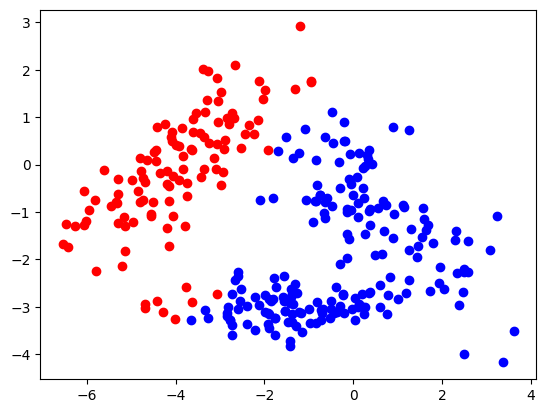

In [ ]:
""" clustCE2.py """
import numpy as np
from numpy import genfromtxt
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

def S(x,D):
    V1 = np.where(x==0)[0] # {V1,V2} is the partition
    V2 = np.where(x==1)[0]
    tmp = D[V1]
    tmp = tmp[:,V2]
    return np.mean(tmp) # the size of the cut

def maxcut(D,N,eps,rho,alpha):
    n = D.shape[1]
    Ne = int(rho*N)
    p = 1/2*np.ones(n)
    p[0] = 1.0
    while (np.max(np.minimum(p,np.subtract(1,p))) > eps):
        x = np.array(np.random.uniform(0,1, (N,n))<=p, dtype=np.int64)
        sx = np.zeros(N)
        for i in range(N):
            sx[i] = S(x[i],D)

        sortSX = np.flip(np.argsort(sx))
        elIds = sortSX[0:Ne]
        elites = x[elIds]
        pnew = np.mean(elites, axis=0)
        p = alpha*pnew + (1.0-alpha)*p

    return np.round(p)

Xmat = genfromtxt('clusterdata.csv', delimiter=',')
n = Xmat.shape[0]

D = squareform(pdist(Xmat))

N = 1000
eps = 10**-2
rho = 0.1
alpha = 0.9

# CE
pout = maxcut(D,N,eps,rho, alpha);

cutval = S(pout,D)
print("cutvalue ",cutval)
#plot
V1 = np.where(pout==0)[0]
xblue = Xmat[V1]
V2 = np.where(pout==1)[0]
xred = Xmat[V2]
plt.scatter(xblue[:,0],xblue[:,1], c="blue")
plt.scatter(xred[:,0],xred[:,1], c="red")

# 4.8 Principal Component Analysis (PCA)

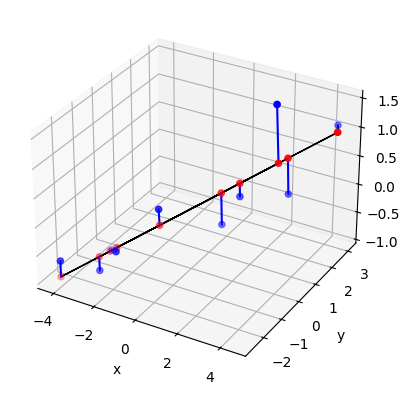

In [ ]:
""" PCAdat.py """
import numpy as np
X = np.genfromtxt('https://raw.githubusercontent.com/DSML-book/Programs/refs/heads/master/Chapter4/pcadat.csv', delimiter=',')
n = X.shape[0]

# Gram matrix
X = X - X.mean(axis=0)
G = X.T @ X
U, _ , _ = np.linalg.svd(G/n)

# projected points
Y = X @ np.outer(U[:,0],U[:,0])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.plot(Y[:,0], Y[:,1], Y[:,2], c='k', linewidth=1)
ax.scatter(X[:,0], X[:,1], X[:,2], c='b')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c='r')

for i in range(n):
    ax.plot([X[i,0], Y[i,0]], [X[i,1],Y[i,1]], [X[i,2],Y[i,2]], 'b')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
plt.savefig('pca1py.pdf')
plt.show()
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

U = 
 [[-0.3614 -0.6566  0.582   0.3155]
 [ 0.0845 -0.7302 -0.5979 -0.3197]
 [-0.8567  0.1734 -0.0762 -0.4798]
 [-0.3583  0.0755 -0.5458  0.7537]]

 diag(D^2) =  [4.2001 0.2411 0.0777 0.0237]


<Axes: ylabel='Density'>

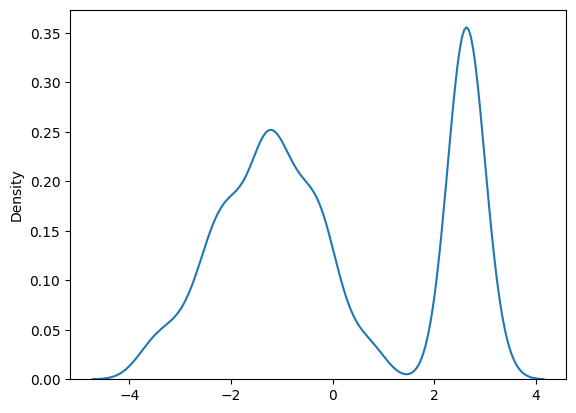

In [ ]:
""" PCAiris.py """
import seaborn as sns, numpy as np

X = np.genfromtxt('https://raw.githubusercontent.com/DSML-book/Programs/refs/heads/master/Chapter4/irisX.csv',delimiter=',')
n = X.shape[0]
X = X - np.mean(X, axis=0)

U, D2, UT = np.linalg.svd((X.T @ X)/n)
print('U = \n', U); print('\n diag(D^2) = ', D2)

z =  U[:,0].T @ X.T

sns.kdeplot(z, bw_method=0.15)